In [1]:
import os, sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))

## Тестовое задание: разработка модуля интеллектуальной валидации данных

In [2]:
import bamt.Networks as Nets
import bamt.Preprocessors as pp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn import preprocessing
from pgmpy.estimators import K2Score

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Извлечение данных и препроцессинг

In [3]:
data = pd.read_csv(r'../data/sangiovese.csv')
data.columns

Index(['Unnamed: 0', 'Treatment', 'SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph'],
      dtype='object')

In [4]:
data = data.loc[:, data.columns != 'Unnamed: 0']

In [5]:
encoder     = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(encode='ordinal')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(data)

info = p.info

### Обучение структур БС с различными гиперпараметрами

Выберем следующий набор параметров для структурного обучения сетей:

1. Разрешенные logit узлы и смеси гауссовских распределений, K2 скор-функция
2. Запрещенные logit узлы и смеси гауссовских распределений, K2 скор-функция
3. Запрещенные logit узлы и смеси гауссовских распределений, BIC скор-функция
4. Запрещенные logit узлы и смеси гауссовских распределений, MI скор-функция

Ниже инициализируем каждую БС и узлы к ним, задаем скор-функции

In [6]:
bn_1 = Nets.HybridBN(has_logit=True, use_mixture=True)
bn_1.add_nodes(info)
bn_1.add_edges(discretized_data, scoring_function=('K2',K2Score))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [7]:
bn_2 = Nets.HybridBN(has_logit=False, use_mixture=False)
bn_2.add_nodes(info)
bn_2.add_edges(discretized_data, scoring_function=('K2',K2Score))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [8]:
bn_3 = Nets.HybridBN(has_logit=False, use_mixture=False)
bn_3.add_nodes(info)
bn_3.add_edges(discretized_data, scoring_function=('BIC', ))

In [9]:
bn_4 = Nets.HybridBN(has_logit=False, use_mixture=False)
bn_4.add_nodes(info)
bn_4.add_edges(discretized_data, scoring_function=('MI',))

Проводим параметрическое обучение сетей

In [10]:
bn_1.fit_parameters(data)

In [11]:
bn_2.fit_parameters(data)

In [12]:
bn_3.fit_parameters(data)

In [13]:
bn_4.fit_parameters(data)

Далее проводим сэмплирование для узла 'Treatment', инициализируя его случайным значением из датасета.

In [14]:
value_treatm = random.choice(data['Treatment'])

In [15]:
sample_1 = bn_1.sample(1000, evidence={'Treatment': value_treatm}, parall_count=5)
sample_2 = bn_2.sample(1000, evidence={'Treatment': value_treatm}, parall_count=5)
sample_3 = bn_3.sample(1000, evidence={'Treatment': value_treatm}, parall_count=5)
sample_4 = bn_4.sample(1000, evidence={'Treatment': value_treatm}, parall_count=5)

100%|██████████| 1000/1000 [00:00<00:00, 2073.09it/s]


Сравним сэмплированные распределение в одном из узлов с исходным распределением

In [16]:
validation_sample = data.loc[data['Treatment'] == value_treatm]
node = 'GrapeW'

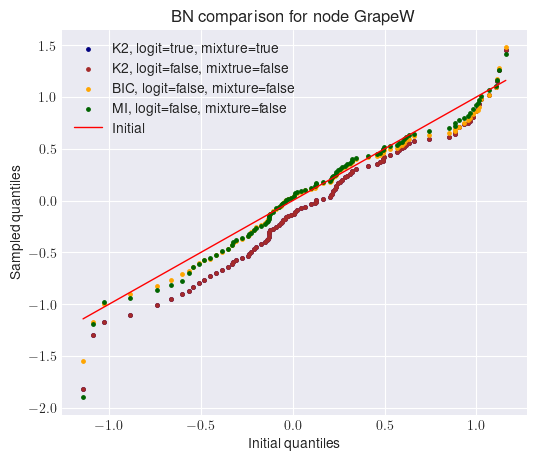

In [17]:
q_control = np.percentile(validation_sample[node].values, range(100))
q_sample_1  = np.percentile(sample_2[node].values, range(100))
q_sample_2  = np.percentile(sample_2[node].values, range(100))
q_sample_3  = np.percentile(sample_3[node].values, range(100))
q_sample_4  = np.percentile(sample_4[node].values, range(100))


plt.scatter(q_control, q_sample_1, s=6, c='navy', label='K2, logit=true, mixture=true')
plt.scatter(q_control, q_sample_2, s=6, c='brown', label='K2, logit=false, mixtrue=false')
plt.scatter(q_control, q_sample_3, s=6, c='orange', label='BIC, logit=false, mixture=false')
plt.scatter(q_control, q_sample_4, s=6, c='darkgreen', label='MI,  logit=false, mixture=false')

plt.plot(q_control, q_control, c='r', label='Initial', linewidth=1)
plt.xlabel('Initial quantiles')
plt.ylabel('Sampled quantiles')
plt.title(f'BN comparison for node {node}')

plt.legend()

### Выводы

Как можно видеть из квантильного биплота, параметризированные с К2 скор-функцией БС 1 и 2 моделируют распределение хуже всего.
Притом наличие logit узлов не влияет на результат (распределения 1 и 2 БС совпадают), поскольку в наборе данных всего одна дискретная переменная.

Лучший результат демонстрирует сеть с заданной MI скор-функцией.